In [ ]:
# HÜCRE 1: Kütüphaneler ve Sabitler (DenseNet)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import copy
import time
import warnings


warnings.filterwarnings("ignore")

# --- AYARLAR ---
VERI_YOLU = r"D:\hamza\derin_ogrenme_proje\2012-09-12"


NUM_FOLDS = 5        
NUM_EPOCHS = 5       
BATCH_SIZE = 32
LEARNING_RATE = 0.001
SEED = 42            

# Seed sabitleme 
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.deterministic = True

seed_everything(SEED)

# --- DONANIM SEÇİMİ ---
if torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print(f"✅ [SİSTEM] Apple Silicon (M1/M2/M3) GPU Aktif.")
elif torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print(f"✅ [SİSTEM] NVIDIA CUDA GPU Aktif.")
else:
    DEVICE = torch.device("cpu")
    print(f"⚠️ [SİSTEM] GPU Bulunamadı. İşlemci (CPU) kullanılıyor.")

✅ [SİSTEM] NVIDIA CUDA GPU Aktif.


📊 Sınıf Dağılımı: {'Empty': 14032, 'Occupied': 18295}


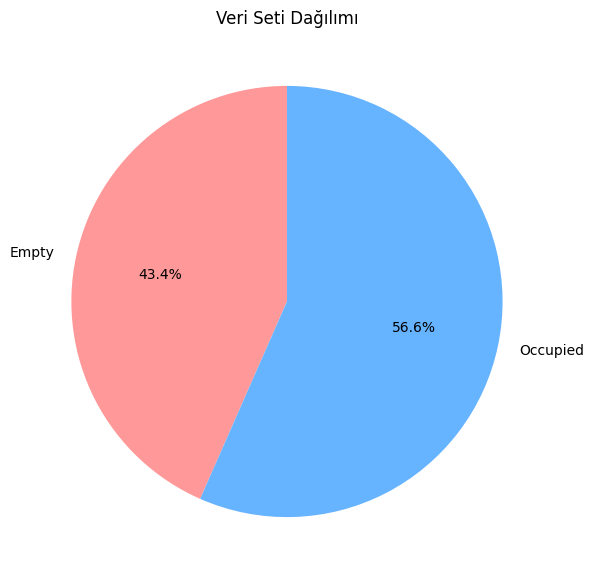

In [ ]:
# HÜCRE 2: Veri Analizi ve Sınıf Dağılımı
if not os.path.exists(VERI_YOLU):
    raise FileNotFoundError(f"HATA: Klasör bulunamadı: {VERI_YOLU}")

# Geçici veri seti yükle
temp_dataset = datasets.ImageFolder(VERI_YOLU)
classes = temp_dataset.classes
targets = temp_dataset.targets

class_counts = {classname: targets.count(i) for i, classname in enumerate(classes)}
print(f"📊 Sınıf Dağılımı: {class_counts}")

# Pasta Grafiği Çiz 
plt.figure(figsize=(7, 7))
plt.pie(class_counts.values(), labels=class_counts.keys(), autopct='%1.1f%%', 
        colors=['#ff9999','#66b3ff'], startangle=90)
plt.title('Veri Seti Dağılımı')
plt.show()

In [ ]:
# HÜCRE 3: Dönüşümler ve Dataset Wrapper
class MapDataset(Dataset):
    def __init__(self, dataset, map_fn):
        self.dataset = dataset
        self.map = map_fn

    def __getitem__(self, index):
        if self.map:     
            x = self.map(self.dataset[index][0]) 
        else:     
            x = self.dataset[index][0]  
        y = self.dataset[index][1]   
        return x, y

    def __len__(self):
        return len(self.dataset)

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [ ]:
# HÜCRE 4: DenseNet121 Model Tanımlama
def get_densenet_model():
    # DenseNet121 indiriliyor
    model = models.densenet121(weights='DEFAULT')
    
    # Parametreleri dondur (Transfer Learning)
    for param in model.parameters():
        param.requires_grad = False
    
    # DenseNet'in sınıflandırıcısı 'classifier' ismindedir.
    
    num_ftrs = model.classifier.in_features
    
    # Binary Classification (2 Sınıf) için son katmanı değiştiriyoruz
    model.classifier = nn.Sequential(
        nn.Linear(num_ftrs, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 2) # Empty, Occupied
    )
    
    return model.to(DEVICE)

In [ ]:
# HÜCRE 5: Stratified K-Fold Eğitim Döngüsü ve Grafikleme (DenseNet)

# --- AYARLAR ---
NUM_FOLDS = 5  

base_dataset = datasets.ImageFolder(VERI_YOLU)
targets_np = np.array(base_dataset.targets)

skf = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)

fold_results = []
best_model_wts = None
best_overall_acc = 0.0

# Son fold verilerini saklamak için
last_fold_data = {}

print(f"\n🚀 DENSENET EĞİTİMİ BAŞLIYOR ({NUM_FOLDS} Fold - {DEVICE})")
print("="*60)

for fold, (train_idx, val_idx) in enumerate(skf.split(np.zeros(len(targets_np)), targets_np)):
    
    print(f"\n>>> FOLD {fold+1}/{NUM_FOLDS} EĞİTİMİ")
    
    # Veri Hazırlığı
    train_sub = torch.utils.data.Subset(base_dataset, train_idx)
    val_sub = torch.utils.data.Subset(base_dataset, val_idx)
    
    train_data = MapDataset(train_sub, train_transforms)
    val_data = MapDataset(val_sub, val_transforms)
    
    # Windows/Mac uyumluluğu için num_workers=0
    train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
    
    model = get_densenet_model()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.classifier.parameters(), lr=LEARNING_RATE)
    
    # Grafik verilerini tutacak listeler
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    
    # Epoch Döngüsü
    for epoch in range(NUM_EPOCHS):
        # --- TRAIN ---
        model.train()
        running_loss = 0.0
        correct_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels.data)
            
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = correct_train.float() / len(train_loader.dataset)
        
        # --- VALIDATION ---
        model.eval()
        val_loss_running = 0.0
        correct_val = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss_running += loss.item() * inputs.size(0)
                
                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels.data)
                
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        epoch_val_loss = val_loss_running / len(val_loader.dataset)
        epoch_val_acc = correct_val.float() / len(val_loader.dataset)
        
        # Listelere ekle
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accs.append(epoch_train_acc.item())
        val_accs.append(epoch_val_acc.item())
        
        print(f"  Epoch {epoch+1}/{NUM_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")

    # --- FOLD BİTİMİNDE GRAFİK ÇİZ VE KAYDET ---
    plt.figure(figsize=(12, 5))
    
    # Loss Grafiği
    plt.subplot(1, 2, 1)
    plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Train Loss')
    plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Val Loss', linestyle='--')
    plt.title(f'DenseNet Fold {fold+1} Loss Değişimi')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Accuracy Grafiği
    plt.subplot(1, 2, 2)
    plt.plot(range(1, NUM_EPOCHS+1), train_accs, label='Train Acc')
    plt.plot(range(1, NUM_EPOCHS+1), val_accs, label='Val Acc', linestyle='--')
    plt.title(f'DenseNet Fold {fold+1} Accuracy Değişimi')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f'DenseNet_Fold_{fold+1}_Grafik.png') 
    plt.show()
    
    # Metrikleri Kaydet
    acc = accuracy_score(val_labels, val_preds)
    f1 = f1_score(val_labels, val_preds, average='weighted')
    prec = precision_score(val_labels, val_preds, average='weighted')
    rec = recall_score(val_labels, val_preds, average='weighted')
    
    fold_results.append({
        'Fold': fold + 1,
        'Accuracy': acc,
        'F1-Score': f1,
        'Precision': prec,
        'Recall': rec
    })
    
    # En iyi model kontrolü
    if acc > best_overall_acc:
        best_overall_acc = acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
    # Son fold verisi (Confusion Matrix için)
    if fold == NUM_FOLDS - 1:
        last_fold_data = {
            'labels': val_labels,
            'preds': val_preds,
            'loader': val_loader
        }

# En iyi modeli kaydet
final_model = get_densenet_model()
final_model.load_state_dict(best_model_wts)
torch.save(final_model.state_dict(), "FET312_DenseNet121_BestModel.pth")
print("\n✅ Tüm Fold'lar tamamlandı. Grafikler kaydedildi.")


🚀 DENSENET EĞİTİMİ BAŞLIYOR (5 Fold - cuda)

>>> FOLD 1/5


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\klask/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:02<00:00, 14.3MB/s]


    Fold 1 Sonuç -> Acc: %99.16 | F1: 0.9916

>>> FOLD 2/5
    Fold 2 Sonuç -> Acc: %99.30 | F1: 0.9930

>>> FOLD 3/5
    Fold 3 Sonuç -> Acc: %99.55 | F1: 0.9955

>>> FOLD 4/5
    Fold 4 Sonuç -> Acc: %99.21 | F1: 0.9921

>>> FOLD 5/5
    Fold 5 Sonuç -> Acc: %99.49 | F1: 0.9949

✅ DenseNet Eğitimi Tamamlandı.



🏆 DENSENET PERFORMANS TABLOSU
          Fold  Accuracy  F1-Score  Precision  Recall
0          1.0    0.9916    0.9916     0.9917  0.9916
1          2.0    0.9930    0.9930     0.9931  0.9930
2          3.0    0.9955    0.9955     0.9955  0.9955
3          4.0    0.9921    0.9921     0.9922  0.9921
4          5.0    0.9949    0.9949     0.9949  0.9949
ORTALAMA   3.0    0.9934    0.9934     0.9935  0.9934


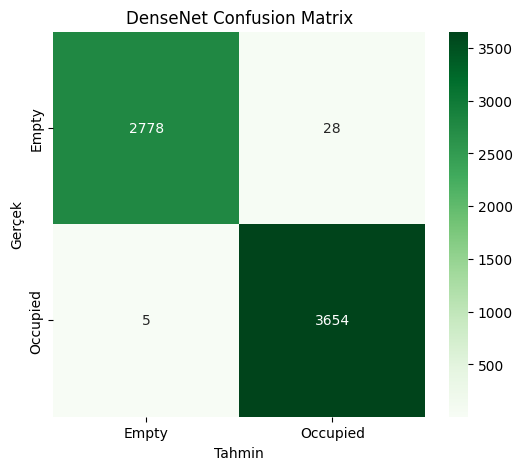

In [ ]:
# HÜCRE 6: Sonuç Raporlama (DenseNet)

# 1. Metrik Tablosu
df_results = pd.DataFrame(fold_results)
df_mean = pd.DataFrame([df_results.mean()], index=["ORTALAMA"])
df_final = pd.concat([df_results, df_mean])

print("\n🏆 DENSENET PERFORMANS TABLOSU")
print("="*60)
print(df_final.round(4))
print("="*60)

# CSV Olarak Kaydet
df_final.to_csv("DenseNet_Performans_Tablosu.csv")

# 2. Confusion Matrix (Son Fold İçin)
plt.figure(figsize=(6, 5))
cm = confusion_matrix(last_fold_data['labels'], last_fold_data['preds'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=classes, yticklabels=classes)
plt.title('DenseNet Confusion Matrix')
plt.ylabel('Gerçek Sınıf')
plt.xlabel('Tahmin Edilen Sınıf')
plt.savefig('DenseNet_Confusion_Matrix.png')
plt.show()

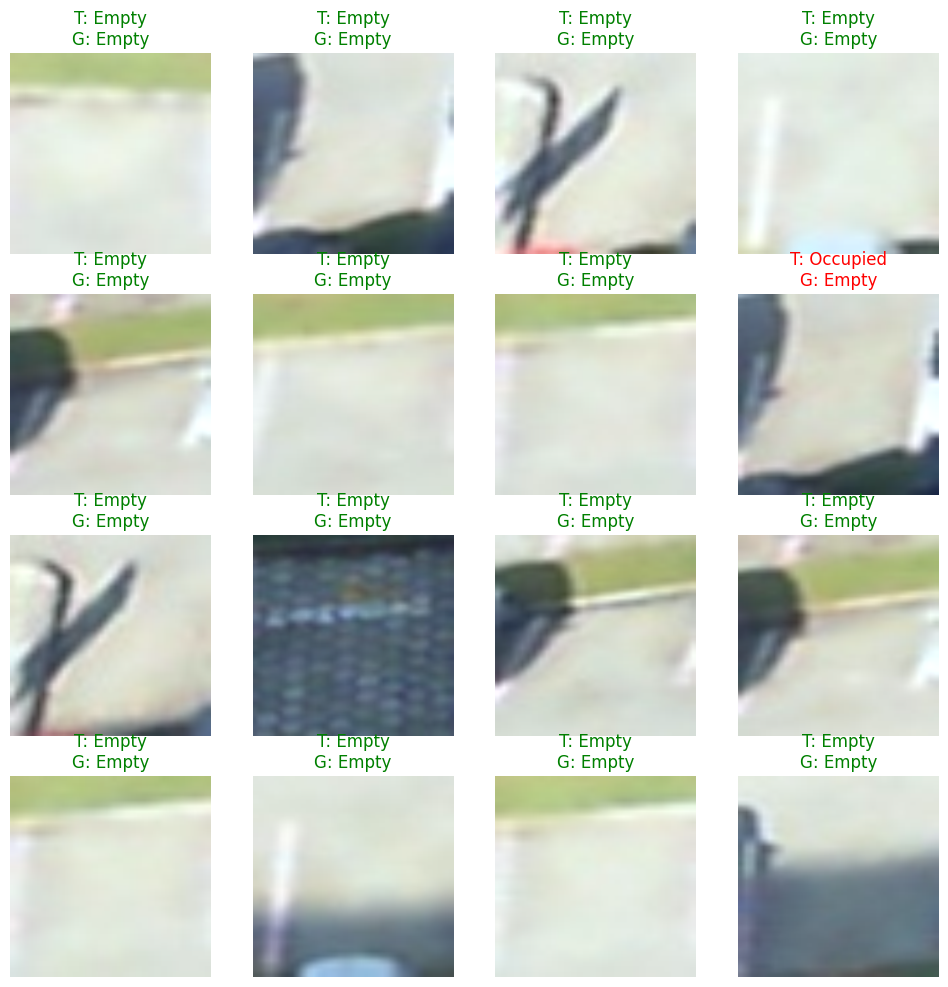

In [ ]:
# HÜCRE 7: Çoklu Tahmin Görselleştirme 

def visualize_multiple_batches(model, loader, num_files=5):
    model.eval()
    iterator = iter(loader)
    
    print(f"\n[SİSTEM] {num_files} adet farklı tahmin dosyası oluşturuluyor...")
    
    for i in range(num_files):
        try:
            images, labels = next(iterator)
        except StopIteration:
            # Loader biterse baştan başlat
            iterator = iter(loader)
            images, labels = next(iterator)
            
        images = images.to(DEVICE)
        
        with torch.no_grad():
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
        plt.figure(figsize=(12, 12))
        
        # Batch içindeki ilk 16 görüntüyü çiz
        for j in range(min(16, len(images))):
            ax = plt.subplot(4, 4, j + 1)
            
            # Görüntüyü normalize halden kurtar
            img = images[j].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            
            plt.imshow(img)
            
            # Doğruysa Yeşil, Yanlışsa Kırmızı Başlık
            if preds[j] == labels[j]:
                color = 'green'
                status = "D" 
            else:
                color = 'red'
                status = "Y" 
                
            title_text = f"T: {classes[preds[j]]}\nG: {classes[labels[j]]}"
            ax.set_title(title_text, color=color, fontsize=10, fontweight='bold')
            plt.axis('off')
        
        plt.tight_layout()
        filename = f'DenseNet_Ornek_Tahminler_{i+1}.png'
        plt.savefig(filename)
        plt.show()
        print(f"   -> '{filename}' kaydedildi.")

# Fonksiyonu çalıştır
visualize_multiple_batches(final_model, last_fold_data['loader'], num_files=5)
print("\n✅ Tüm işlemler başarıyla tamamlandı.")